In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle as pkl

In [2]:
from shuttle_helpers import load
c = 0 #index of the conditional variable variable
train, test = load(c=c)
# too big to easily process on 1 GPU.
# Let us split it in 3 datasets
seed = 2
assert (seed>=0) & (seed<=2)
train = train[seed::3]
test  =  test[seed::3]
print(train.shape, test.shape)

(14500, 10) (4833, 10)


In [3]:
import sys
sys.path.insert(0, '../../') #back to the project folder from ./examples/shuttle/
from marginal import heuristic_element_order
numbers = np.concatenate([train,test])
order = heuristic_element_order(numbers) 
# order is different for train vs. test, but we follow the vine.R by Hernandez-Lobato
order

array([7, 4, 9, 8, 0, 6, 2, 5, 1, 3])

In [5]:
import marginal as mg
from tqdm.notebook import tqdm
X = train[:,c]
Xt = test[:,c]
Y_raw = train[:,order[order!=c]]
Yt_raw = test[:,order[order!=c]]
# conditional
Y = np.zeros_like(Y_raw)
Yt = np.zeros_like(Yt_raw)
for i, (y,yt) in tqdm(enumerate(zip(Y_raw.T,Yt_raw.T))):
    # conditional
    Y[:,i] = np.clip(mg.fast_signal2uniform(y,X),0.001,0.999)
    Yt[:,i] = np.clip(mg.fast_signal2uniform(y,X,Y_=yt,X_=Xt),0.001,0.999)
    # unconditional
#     Y[:,i] = (np.argsort(Y_raw[:,i].flatten()).argsort()/Y_raw[:,i].size)\
#                 .reshape(Y_raw[:,i].shape)
#     Yt[:,i] = (np.argsort(Yt_raw[:,i].flatten()).argsort()/Yt_raw[:,i].size)\
#                  .reshape(Yt_raw[:,i].shape)

# # now [0,1] -> [0.001,0.999] for computational stability
# min = np.concatenate([y,yt]).min(0)
# max = np.concatenate([y,yt]).max(0)
# Y = normalize_Y(y,min,max)
# Yt = normalize_Y(yt,min,max)

(14500,)

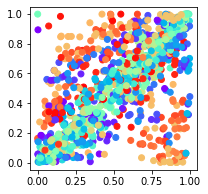

In [6]:
import matplotlib.cm as cm

plt.figure(figsize=(3,3))
skip = 4
plt.scatter(*Yt[::skip,[0,4]].T,color=cm.rainbow(Xt[::skip]))
X.shape

In [18]:
##############################
#       Train                #
##############################

# # Option 1: light (no files saved to disk)
# from train import train_vine_light

# gpus = [0,1]
# %time result = train_vine_light(X,Y,gauss=True,device_list=[f'cuda:{i}' for i in gpus])
# trained = {'X': X, 'Xt': Xt, 'Y': Y, 'Yt': Yt, 'X_label' : 'time'}
# trained.update(result)

# path_final = f"/home/nina/CopulaGP/examples/shuttle/outputs/shuttleG_trained.pkl"
# with open(path_final,"wb") as f:
#     pkl.dump(trained,f)

In [24]:
# Option 2: layer by layer, saving checkpoints
from train import train_vine

# first, set up the pathes

path2data = '/home/nina/CopulaGP/examples/shuttle'
exp = f'shuttle{seed}'
g = 'G'
path_data = lambda layer: f"{path2data}/outputs/{exp}{g}_layer{layer}.pkl"
path_models = lambda layer: f"{path2data}/outputs/{exp}{g}_models_layer{layer}.pkl"
path_final = f"{path2data}/outputs/{exp}{g}_trained.pkl"

# d = {'X': X, 'Xt': Xt, 'Y': Y, 'Yt': Yt, 'X_label' : 'time'}
# with open(path_data(0),'wb') as f:
#     pkl.dump(d,f)

# # train it here ...
# gpus = [0,1]
# %time result = train_vine(exp, path_data, path_models, path_final, \
#                           gauss=False, start=1, device_list=[f'cuda:{i}' for i in gpus])
# # ... or run 'python train.py -exp shuttle2' (or other shuttle{seed}) in terminal
    
with open(path_final,"rb") as f:
    trained = pkl.load(f)

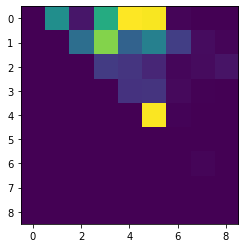

In [25]:
NN = len(trained['waics'][0])+1
WAICs = np.zeros((NN,NN))
for layer, ws in enumerate(trained['waics']):
    WAICs[layer,(layer+1):] = [-a for a in ws]
plt.imshow(WAICs[:])

In [26]:
device='cuda:0'
#real
test_x = torch.tensor(trained['Xt'], device=device).float()
test_y = torch.tensor(trained['Yt'], device=device).float()

In [27]:
from vine import CVine
vine_base = CVine.marginalize(trained['models'],test_x,device=device)
copgp = vine_base.log_prob(test_y).mean()
vine = vine_base.truncate(5)
copgpT = vine.log_prob(test_y).mean()

(copgp,copgpT)

(tensor(3.5944, device='cuda:0'), tensor(2.8403, device='cuda:0'))

In [23]:
# calculate marginal conditional entropies H(Y_i|X)
from MI import HYgX
HYgX(numbers[::10,0],numbers[::10,1:])

[-0.4257869589924959,
 -3.9902994054185275,
 -3.535800447707821,
 0.786230017110263,
 -0.5837155760054847,
 2.0484361502589308,
 -2.9737751796617498,
 -8.157119701758269]

In [17]:
trained['models']
    # # plot results
# plot_res = '{}/res_{}.png'.format(path_output,name)
# # print(X.shape,Y.shape,name_x,name_y,plot_res)
# Plot_Fit(model,X,Y,name_x,name_y,plot_res,device=device)

[[<bvcopula.models.Pair_CopulaGP_data at 0x7f4fdccfe7b8>,